In [1]:
from kan import create_dataset, KAN
from kansr import KANSR
import openai
import LLMSR

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)
LLMSR.llm.check_key_limit(client)

39.5523914

# Try library

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAN(width=[1,4,1], grid=7, k=3, seed=17, device=device, symbolic_enabled=False)
kan_sr = KANSR(model, client)

# create dataset
f = lambda x: (x**3 + torch.pi)**2
ranges = [-2, 2]
dataset = create_dataset(f, n_var=1, ranges=ranges, train_num=10000, test_num=1000, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [27]:
# train KAN
kan_sr.train_kan(dataset)

| train_loss: 2.51e-02 | test_loss: 2.50e-02 | reg: 3.07e+01 | : 100%|█| 50/50 [00:22<00:00,  2.27it

saving model version 0.1
saving model version 0.2


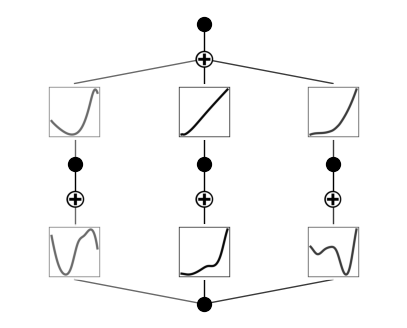

In [28]:
kan_sr.model.plot()

In [29]:
# fit KAN
simplified_expressions, refitted_expressions, final_expressions = kan_sr.get_symbolic(population=10, generations=3)

2025-03-11 15:11:13,554 - INFO - Processing KAN connection (0, 0, 0)


Checking constant function
Constant function is not a good fit.
Score:  -0.39282144153923143
Constant:  [-2.13142307]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [01:09<00:00,  6.90s/it]


Best score:  -0.26809582
Best ansatz:   params[0] + params[1] * x
Best params:  [-2.10624544  0.77879889]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [01:23<00:00,  8.33s/it]


Best score:  -0.039175853
Best ansatz:   params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3]
Best params:  [ 1.80477896  1.62150375  0.36092725 -2.60796848]
Generation: 2


 30%|█████████████▏                              | 3/10 [00:21<00:58,  8.42s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Getting another response from LLM


100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.34s/it]
2025-03-11 15:14:59,379 - INFO - Processing KAN connection (0, 0, 1)


Best score:  -0.035299998
Best ansatz:   params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4]
Best params:  [ 1.88865296  1.48926915 -0.07927554  0.35964355 -2.6081026 ]
Checking constant function
Constant function is not a good fit.
Score:  -3.9172081504785345
Constant:  [0.88781396]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:30<00:00,  3.08s/it]


Best score:  -27.313126
Best ansatz:   params[0] + params[1] * x
Best params:  [0.92954102 1.29070929]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [01:01<00:00,  6.18s/it]


Best score:  -29.379906
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [0.09093413 1.31575253 0.6146498 ]
Generation: 2


100%|███████████████████████████████████████████| 10/10 [00:53<00:00,  5.30s/it]
2025-03-11 15:17:25,128 - INFO - Processing KAN connection (0, 0, 2)


Best score:  -180.5436
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [0.06640231 0.51190783 0.63804953 0.33495338]
Checking constant function
Constant function is not a good fit.
Score:  -3.919874335484253
Constant:  [-2.53351311]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:46<00:00,  4.68s/it]


Best score:  -198.0363
Best ansatz:  params[0] * x
Best params:  [-1.52437107]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.87s/it]


Best score:  -5.609508
Best ansatz:   params[0] * np.sin(params[1] * x) + params[2]
Best params:  [-0.96392631 -7.72480838 -2.47989011]
Generation: 2


 50%|██████████████████████                      | 5/10 [00:15<00:14,  2.99s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Getting another response from LLM


100%|███████████████████████████████████████████| 10/10 [00:32<00:00,  3.27s/it]
2025-03-11 15:19:33,389 - INFO - Processing KAN connection (1, 0, 0)


Best score:  -5.8637776
Best ansatz:   params[0] * np.cos(params[1] * x) + params[2]
Best params:  [-1.58886341e+04 -8.61993766e-03  1.58852944e+04]
Checking constant function
Constant function is not a good fit.
Score:  -3.3481851730966175
Constant:  [2.86770432]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:35<00:00,  3.54s/it]


Best score:  -370.70847
Best ansatz:   params[0] + params[1] * x
Best params:  [9.03812718 2.89497799]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:43<00:00,  4.36s/it]


Best score:  -10.470166
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [18.27306455 15.20719797  2.53158568 -0.04581868]
Generation: 2


100%|███████████████████████████████████████████| 10/10 [01:03<00:00,  6.33s/it]
2025-03-11 15:21:55,846 - INFO - Processing KAN connection (1, 1, 0)


Best score:  -404.47903
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3 + params[4] * x**4
Best params:  [ 11.80827774  -5.40882136 -16.49224616  -6.53456303  -0.73078268]
Checking constant function
Constant function is not a good fit.
Score:  -2.946871525455571
Constant:  [9.67177905]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.02s/it]


Best score:  -0.33707538
Best ansatz:   params[0] * x
Best params:  [9.63454529]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:46<00:00,  4.60s/it]


Best score:  -0.26927897
Best ansatz:   params[0] * x**2 + params[1] * x
Best params:  [0.610956   6.82798292]
Generation: 2


100%|███████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]
2025-03-11 15:24:50,080 - INFO - Processing KAN connection (1, 2, 0)


Best score:  -0.17824183
Best ansatz:   params[0] * x**3 + params[1] * x**2 + params[2] * x
Best params:  [-0.25101299  2.50496905  4.27331431]
Checking constant function
Constant function is not a good fit.
Score:  -1.750324905408957
Constant:  [6.01029757]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]


Best score:  -4.4575787
Best ansatz:   params[0] + params[1] * x
Best params:  [9.10200924 1.22032591]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:47<00:00,  4.76s/it]


Best score:  -1.3251938
Best ansatz:   params[0] * np.exp(params[1] * x)
Best params:  [6.9073148  0.20885669]
Generation: 2


 30%|█████████████▏                              | 3/10 [00:21<00:59,  8.45s/it]<string>:1: RuntimeWarning: invalid value encountered in power
/Users/ruehle/GitHub/LLM_SR/LLMSR/fit.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  params_opt, _ = curve_fit(curve, x, y, p0=params_initial)
100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.83s/it]
2025-03-11 15:26:49,892 - INFO - Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4]
2025-03-11 15:26:49,893 - INFO - Parameters are [ 1.9  1.5 -0.1  0.4 -2.6]
2025-03-11 15:26:49,894 - INFO - Approximation for (0, 0, 1): params[0] + params[1] * x
2025-03-11 15:26:49,895 - INFO - Parameters are [0.9 1.3]
2025-03-11 15:26:49,896 - INFO - Approximation for (0, 0, 2): params[0] * np.sin(params[1] * x) + params[2]
2025-03-11 15:26:49,897 - INFO - Parameters are [-1.  -7.7 -2.5]
2025-03-11 15:26:49,898 - INFO - Approximation for (1, 0, 0): 

Best score:  -3.6811485
Best ansatz:   params[0] + params[1] * x**2
Best params:  [ 7.12298098 -0.03523475]


2025-03-11 15:26:51,376 - INFO - ###################################################
2025-03-11 15:26:51,377 - INFO - Simplifying output 0
2025-03-11 15:26:51,377 - INFO - KAN expression (raw):
2025-03-11 15:26:51,377 - INFO - -1.20593096*x0**3 + 5.46850912*x0**2 + 5.51554831*x0 - 0.539696562167393*(x0 + 0.720151855582242)**3 + 4.17309575745*(x0 + 0.720151855582242)**2 + 0.812527737256398*(0.030405275871324*x0**3 - 0.137878148843986*x0**2 - 0.724167018135808*sin(1.4893*x0) + 1.0)**3 + 17.220413090276*(0.030405275871324*x0**3 - 0.137878148843986*x0**2 - 0.724167018135808*sin(1.4893*x0) + 1.0)**2 + 4.11454276344339*exp(0.20135871*sin(7.7248*x0)) + 28.72183864*sin(1.4893*x0) - 17.41676597
2025-03-11 15:26:57,486 - INFO - KAN expression (simplified):
2025-03-11 15:26:57,486 - INFO - -1.2059*x0**3 + 5.4685*x0**2 + 5.5155*x0 - 0.5397*(x0 + 0.7202)**3 + 4.1731*(x0 + 0.7202)**2 + 0.8125*(0.0304*x0**3 - 0.1379*x0**2 - 0.7242*sin(1.4893*x0) + 1.0)**3 + 17.2204*(0.0304*x0**3 - 0.1379*x0**2 - 0.72

In [30]:
simplified_expressions, refitted_expressions, final_expressions

(['-1.2059*x0**3 + 5.4685*x0**2 + 5.5155*x0 - 0.5397*(x0 + 0.7202)**3 + 4.1731*(x0 + 0.7202)**2 + 0.8125*(0.0304*x0**3 - 0.1379*x0**2 - 0.7242*sin(1.4893*x0) + 1.0)**3 + 17.2204*(0.0304*x0**3 - 0.1379*x0**2 - 0.7242*sin(1.4893*x0) + 1.0)**2 + 4.1145*exp(0.2014*sin(7.7248*x0)) + 28.7218*sin(1.4893*x0) - 17.4168'],
 ['-1.2059*x0**3 + 5.4685*x0**2 + 5.5155*x0 - 0.5397*(x0 + 0.7202)**3 + 4.1731*(x0 + 0.7202)**2 + 0.8125*(0.0304*x0**3 - 0.1379*x0**2 - 0.7242*sin(1.4893*x0) + 1.0)**3 + 17.2204*(0.0304*x0**3 - 0.1379*x0**2 - 0.7242*sin(1.4893*x0) + 1.0)**2 + 4.1145*exp(0.2014*sin(7.7248*x0)) + 28.7218*sin(1.4893*x0) - 17.4168'],
 ['6.2213*x0**3 + 11.548*x0**2 + 0.0783*x0 + 3.7939'])

## Some optional plots

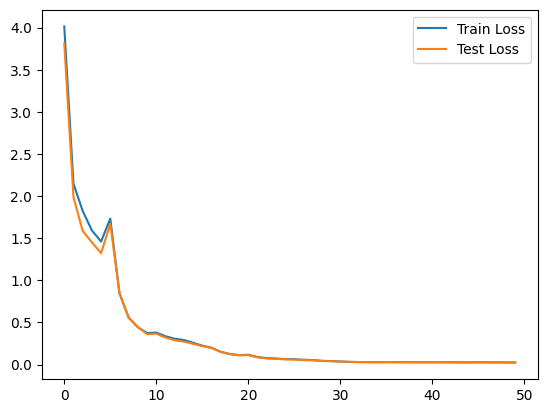

In [32]:
plt.plot(range(len(kan_sr.training_history['train_loss'])), [x.item() for x in kan_sr.training_history['train_loss']], label="Train Loss");
plt.plot(range(len(kan_sr.training_history['test_loss'])), [x.item() for x in kan_sr.training_history['test_loss']], label="Test Loss");
plt.legend();

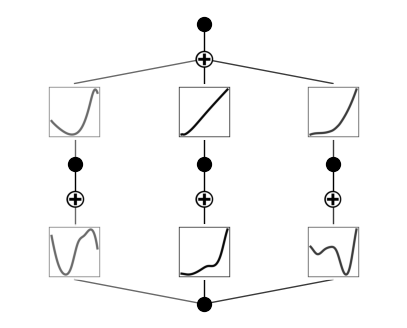

In [33]:
kan_sr.model.plot()

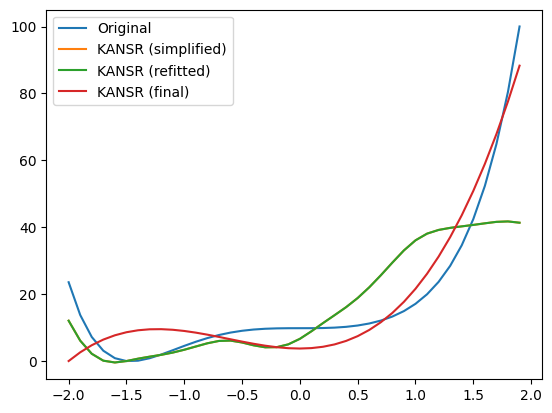

In [34]:
f_orig = lambda x0: (x0**3 + torch.pi)**2
f_simp = lambda x0: eval(simplified_expressions[0])
f_refitted = lambda x0: eval(refitted_expressions[0])
f_final = lambda x0: eval(final_expressions[0])

xs = np.arange(ranges[0], ranges[1], .1)
plt.plot(xs, [f_orig(x) for x in xs], label="Original")
plt.plot(xs, [f_simp(x) for x in xs], label="KANSR (simplified)")
plt.plot(xs, [f_refitted(x) for x in xs], label="KANSR (refitted)")
plt.plot(xs, [f_final(x) for x in xs], label="KANSR (final)")
plt.legend()
plt.show()


# Try $(x^3 + \pi)^2$

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.51e-02 | test_loss: 2.50e-02 | reg: 3.07e+01 | : 100%|█| 50/50 [00:24<00:00,  2.05it


saving model version 0.1


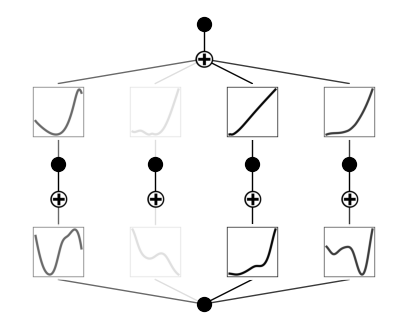

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[1,4,1], grid=7, k=3, seed=17, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: (x**3 + torch.pi) **2
ranges = [-2, 2]
dataset = create_dataset(f, n_var=1, ranges=ranges, train_num=10000, test_num=1000, device=device)
res_kan_training = model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

saving model version 0.2


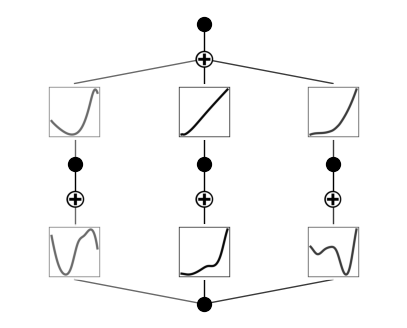

In [24]:
pruned_model = model.prune(node_th=0.2, edge_th=0.2)
pruned_model.plot()

(0, 0, 0)


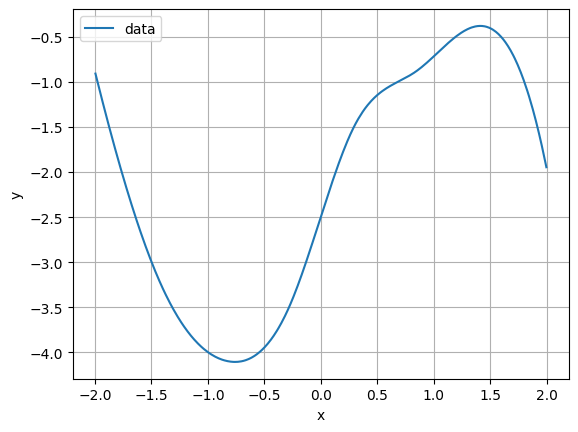

Checking constant function
Constant function is not a good fit.
Score:  -0.39282144153923143
Constant:  [-2.13142307]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.72s/it]


Best score:  -0.26809582
Best ansatz:   params[0] + params[1] * x
Best params:  [-2.10624544  0.77879889]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.40s/it]


Best score:  -0.03344726
Best ansatz:   params[0] * x**3 + params[1] * x**2 + params[2] * x + params[3]
Best params:  [-0.70154355  0.35810997  2.47900013 -2.61032458]
Generation: 2


 20%|████████▊                                   | 2/10 [00:04<00:16,  2.11s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Getting another response from LLM


 60%|██████████████████████████▍                 | 6/10 [00:15<00:11,  2.82s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Getting another response from LLM


100%|███████████████████████████████████████████| 10/10 [00:28<00:00,  2.90s/it]

Best score:  -0.036579166
Best ansatz:   params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4] * x + params[5]
Best params:  [ 2.34078812  1.41949978 -0.01279908  0.34329633 -0.51022801 -2.58322825]
(0, 0, 1)


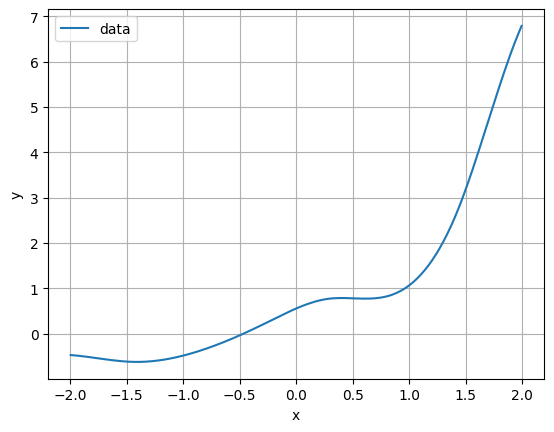

Checking constant function
Constant function is not a good fit.
Score:  -3.9172081504785345
Constant:  [0.88781396]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:32<00:00,  3.21s/it]


Best score:  -27.313126
Best ansatz:  params[0] + params[1] * x
Best params:  [0.92954102 1.29070929]
Generation: 1


 20%|████████▊                                   | 2/10 [00:04<00:17,  2.18s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Getting another response from LLM


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


Best score:  -29.379896
Best ansatz:   params[0] * x**2 + params[1] * x + params[2]
Best params:  [0.6146498  1.31575253 0.09093413]
Generation: 2


 60%|██████████████████████████▍                 | 6/10 [00:18<00:14,  3.72s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Getting another response from LLM


 70%|██████████████████████████████▊             | 7/10 [00:20<00:09,  3.15s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Getting another response from LLM


100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]

Best score:  -180.5436
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [0.06640231 0.51190783 0.63804953 0.33495338]
(0, 0, 2)


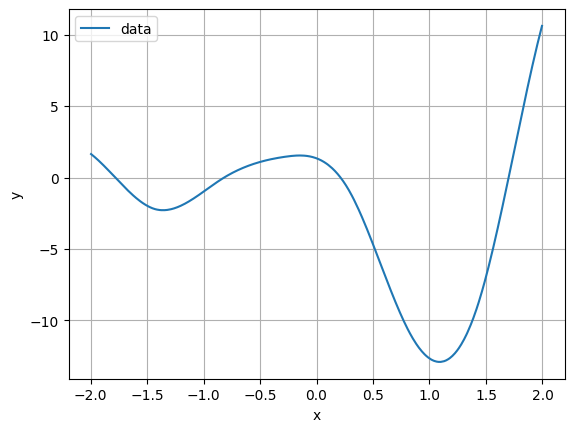

Checking constant function
Constant function is not a good fit.
Score:  -3.919874335484253
Constant:  [-2.53351311]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:30<00:00,  3.04s/it]


Best score:  -198.0363
Best ansatz:   params[0] * x
Best params:  [-1.52437107]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.61s/it]


Best score:  -19.662598
Best ansatz:   params[0] * x + params[1] * np.sin(x)
Best params:  [ 10.77984351 -18.86460802]
Generation: 2


 10%|████▍                                       | 1/10 [00:06<00:54,  6.11s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Getting another response from LLM


100%|███████████████████████████████████████████| 10/10 [00:29<00:00,  2.99s/it]

Best score:  -3.3013182
Best ansatz:   params[0] * x**3 + params[1] * np.cos(x) + params[2]
Best params:  [-0.17459783 -0.80096193 -2.19716201]
(1, 0, 0)


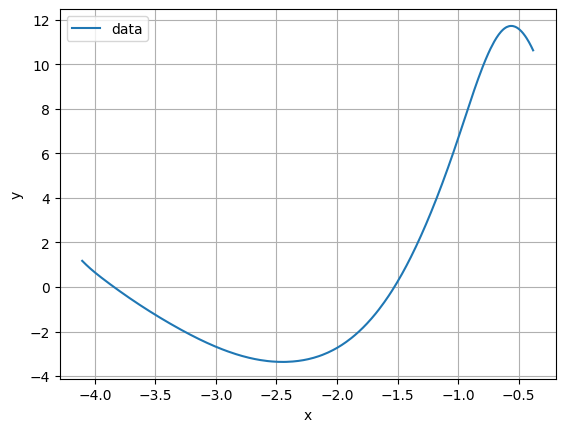

Checking constant function
Constant function is not a good fit.
Score:  -3.3481851730966175
Constant:  [2.86770432]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:36<00:00,  3.69s/it]


Best score:  -370.70847
Best ansatz:   params[0] * x + params[1]
Best params:  [2.89497799 9.03812718]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.59s/it]


Best score:  -884.1657
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [18.5170445  15.76116833  2.83591758]
Generation: 2


100%|███████████████████████████████████████████| 10/10 [00:28<00:00,  2.80s/it]

Best score:  -10.470166
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [18.27306455 15.20719797  2.53158568 -0.04581868]
(1, 1, 0)


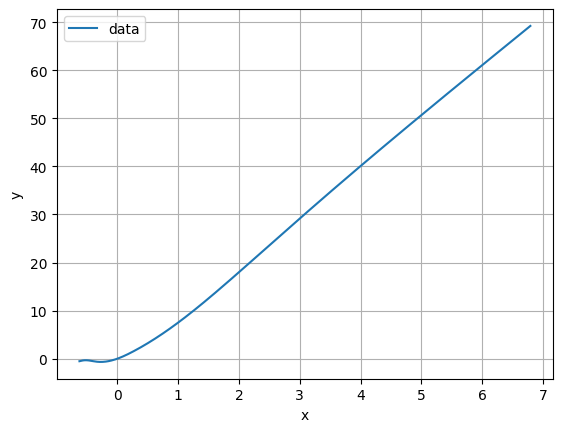

Checking constant function
Constant function is not a good fit.
Score:  -2.946871525455571
Constant:  [9.67177905]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [01:06<00:00,  6.69s/it]


Best score:  -0.33707538
Best ansatz:   params[0] * x
Best params:  [9.63454529]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:55<00:00,  5.54s/it]


Best score:  -0.75313514
Best ansatz:  params[0] + params[1] * x**2 + params[2] * np.exp(x)
Best params:  [ 1.84130315  2.55829691 -0.06804874]
Generation: 2


 50%|██████████████████████                      | 5/10 [01:10<01:21, 16.38s/it]<string>:1: RuntimeWarning: invalid value encountered in sqrt
/Users/ruehle/GitHub/LLM_SR/LLMSR/fit.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  params_opt, _ = curve_fit(curve, x, y, p0=params_initial)
100%|███████████████████████████████████████████| 10/10 [01:53<00:00, 11.30s/it]

Best score:  nan
Best ansatz:  params[0] + params[1] * x + params[2] * np.sqrt(x)
Best params:  [1. 1. 1.]
(1, 2, 0)


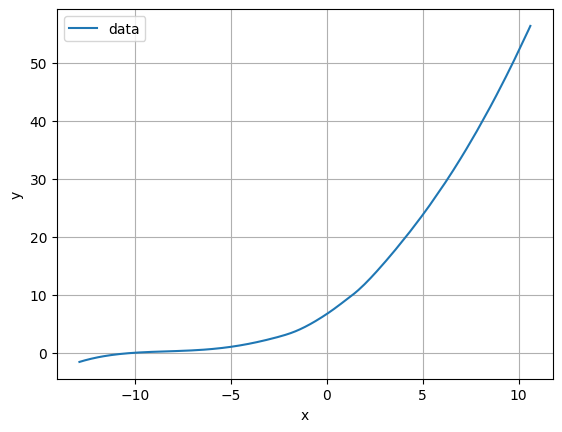

Checking constant function
Constant function is not a good fit.
Score:  -1.750324905408957
Constant:  [6.01029757]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]


Best score:  -4.4575787
Best ansatz:   params[0] + params[1] * x
Best params:  [9.10200924 1.22032591]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.68s/it]


Best score:  -35.446102
Best ansatz:   params[0] * x**2 + params[1] * x + params[2]
Best params:  [0.15531179 2.45415411 7.32331559]
Generation: 2


100%|███████████████████████████████████████████| 10/10 [00:57<00:00,  5.71s/it]

Best score:  -1.4962362
Best ansatz:   params[0] * np.exp(params[1] * x) + params[2]
Best params:  [ 9.6006188   0.17824916 -2.59753665]


In [25]:
sym_expr = LLMSR.kan_to_symbolic(pruned_model, client, gpt_model="openai/gpt-4o", exit_condition=min(res_kan_training['train_loss']).item())


In [26]:
symb_expr_sorted = {}
# build disctionary with all expressions ordered by score
for kan_conn, sub_res in sym_expr.items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    ordered_elements = sorted([item for sublist in sub_res for item in sublist], key=lambda item: -item['score'])
    symb_expr_sorted[kan_conn] = ordered_elements
    print(f"Approximation for {kan_conn}: {ordered_elements[0]['ansatz'].strip()}")
    print(f"Parameters are {np.round(ordered_elements[0]['params'], 1)}")

Approximation for (0, 0, 0): params[0] * x**3 + params[1] * x**2 + params[2] * x + params[3]
Parameters are [-0.7  0.4  2.5 -2.6]
Approximation for (0, 0, 1): params[0] + params[1] * x
Parameters are [0.9 1.3]
Approximation for (0, 0, 2): params[0] * x**3 + params[1] * np.cos(x) + params[2]
Parameters are [-0.2 -0.8 -2.2]
Approximation for (1, 0, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Parameters are [18.3 15.2  2.5 -0. ]
Approximation for (1, 1, 0): params[0] * x
Parameters are [9.6]
Approximation for (1, 2, 0): params[0] * np.exp(params[1] * x) + params[2]
Parameters are [ 9.6  0.2 -2.6]


In [27]:
edge_dict_top_three, edge_dict = {}, {}
for kan_conn, sub_res in symb_expr_sorted.items():
    print(f"KAN Connection: {kan_conn}")
    scores, ansatze, params = [pop['score'] for pop in sub_res], [pop['ansatz'].replace('*x', ' * x').replace('(x)', '(1. * x)') for pop in sub_res], [pop['params'] for pop in sub_res]
    top_three_ansatze, top_three_params, top_three_scores = [], [], []
    for s, a, p in zip(scores, ansatze, params):
        a = a.strip()
        # weed out lambda functions
        if "lambda" in a:
            continue
        if a not in top_three_ansatze and round(s, 5) not in top_three_scores:
            top_three_ansatze.append(a)
            top_three_params.append(p)
            top_three_scores.append(round(s, 5))                
        if len(top_three_ansatze) >= 3:
            break
    top_three = []
    for a, p in zip(top_three_ansatze, top_three_params):
        top_three.append(subst_params(a, p))
    edge_dict_top_three[kan_conn] = top_three
    edge_dict[kan_conn] = top_three[0]
    print([(s,t) for s,t in zip(top_three, top_three_scores)])

KAN Connection: (0, 0, 0)
[('-0.7015 * x**3 + 0.3581 * x**2 + 2.4790 * x + -2.6103', -0.03345), ('2.3408 * np.sin(1.4195 * x + -0.0128) + 0.3433 * x**2 + -0.5102 * x + -2.5832', -0.03658), ('1.8048 * np.sin(1.6215 * x) + 0.3609 * x**2 + -2.6080', -0.03918)]
KAN Connection: (0, 0, 1)
[('0.9295 + 1.2907 * x', -27.31312), ('0.6146 * x**2 + 1.3158 * x + 0.0909', -29.3799), ('0.0664 + 0.5119 * x + 0.6380 * x**2 + 0.3350 * x**3', -180.5436)]
KAN Connection: (0, 0, 2)
[('-0.1746 * x**3 + -0.8010 * np.cos(1. * x) + -2.1972', -3.30132), ('10.7798 * x + -18.8646 * np.sin(1. * x)', -19.6626), ('0.9242 * np.sin(-5.9122 * x) + 0.6220 * x**2 + -3.3340', -70.13471)]
KAN Connection: (1, 0, 0)
[('18.2731 + 15.2072 * x + 2.5316 * x**2 + -0.0458 * x**3', -10.47017), ('9.0381 + 2.8950 * x', -370.70847), ('18.5170 + 15.7612 * x + 2.8359 * x**2', -884.1657)]
KAN Connection: (1, 1, 0)
[('9.6345 * x', -0.33708), ('1.8413 + 2.5583 * x**2 + -0.0680 * np.exp(1. * x)', -0.75314), ('9.3130 * x + 1.4035', -1.09835)

###################################################
Simplifying output 0
KAN expression (raw):
 -10.6678508*x0**3 + 5.44569832*x0**2 + 50.13389795*x0 + 0.814585636838497*(0.268743056353676*x0**3 - 0.137187296479332*x0**2 - 0.949699268283339*x0 + 1)**3 + 17.249477073444*(0.268743056353676*x0**3 - 0.137187296479332*x0**2 - 0.949699268283339*x0 + 1)**2 + 6.49014294904709*exp(-0.03111372*x0**3 - 0.1427382*cos(1.0*x0)) - 15.06448641
KAN expression (simplified):
 0.0158032861902638*x0**9 - 0.0242077878522984*x0**8 - 0.155205932978583*x0**7 + 1.5908675655984*x0**6 - 0.903448485312127*x0**5 - 9.98254952954284*x0**4 + 3.6929024264711*x0**3 + 18.139127681397*x0**2 + 15.04932284*x0 + 6.4901*exp(-0.0311*x0**3 - 0.1427*cos(1.0*x0)) + 2.9996
Refitting gave a chi^2 of 2.3100e-09
KAN expression (final):
 -0.0001*x0**7 + 0.9992*x0**6 + 0.003*x0**5 + 0.0039*x0**4 + 6.3783*x0**3 - 0.1717*x0**2 + 6.2441*exp(-0.0175*x0**3 - 0.1381*cos(0.6763*x0)) + 4.4307
Refitting gave a chi^2 of 1.2506e-09


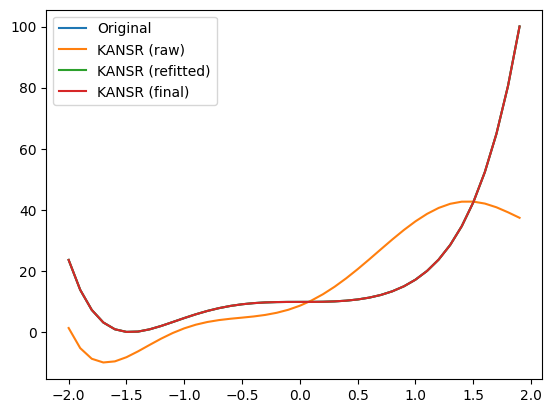

##################
# Final formula: #
##################
 1.0*x0**6 + 6.2832*x0**3 + 9.8696


In [55]:
# define an expression tree consisting of L layers, with N nodes, where node (l,n) = \sum_c expr(l,c,n)
# the KAN convention for the triples (l,c,n) is: (layer, coming from node in l-1, going to node in layer l)
node_tree = {}
for l in range(len(pruned_model.width_in) - 1):
        for n in range(pruned_model.width_in[l+1]):
            node_tree[(l, n)] = " + ".join([edge_dict[(l,c,n)].replace(' x', f' x[{l-1},{c}]' if l > 0 else f' x{c}') for c in range(pruned_model.width_out[l])])
for k, v in node_tree.items():
    node_tree[k] = v.replace('+ -','- ')

# Build full expression, prepopulate with output nodes
full_expression = []
for o in range(pruned_model.width_in[-1]):
    res = node_tree[len(pruned_model.width_in)-2, o]
    # traverse down lower layers
    for l in list(range(len(pruned_model.width_in)-2))[::-1]:
        for n in range(len([x for x in node_tree.keys() if x[0]==l])):
            res = res.replace(f'x[{l},{n}]', f'({node_tree[l, n]})')
    full_expression.append(simplify_expression(res, pruned_model.width_in[0] - 1))

# After simplification, prune (round coefficients to 4 digits), simplify again
final_expressions = []
for i, expr in enumerate(full_expression):
    print("###################################################")
    print(f"Simplifying output {i}")
    print("KAN expression (raw):\n", expr)
    f_fitted = lambda x0: eval(expr)
    xs = np.arange(-2, 2, .1)
    plt.plot(xs, [f(x) for x in xs], label="Original")
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (raw)")
    plt.legend();
    
    # prune and simplify
    expr = simplify_expression(subst_params(*replace_floats_with_params(expr)), pruned_model.width_in[0] - 1)
    print("KAN expression (simplified):\n", expr)

    # refit parameters
    curve_ansatz_str, params_initial = replace_floats_with_params(expr)
    for k, v in sympy_to_numpy.items():
        curve_ansatz_str = curve_ansatz_str.replace(k, v)
    
    curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
    curve = eval(curve_ansatz)
    try:
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")
    except RuntimeError as e:
        print(e)
        print("Proceeding with unoptimized parameters")
        params_opt = params_initial

    # prune and simplify refitted model
    expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
    print("KAN expression (final):\n", expr)
    final_expressions.append(expr)
    
    # plot comparison
    f_fitted = lambda x0: eval(expr)
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (refitted)")
    
    # Ask LLM to further simplify the result and refit.
    try:
        simp_call_reply = call_model_simplify(client, prompt=f"The interval is {ranges}. The function is {expr}.")
        expr = simp_call_reply.choices[0].message.content
        curve_ansatz_str, params_initial = replace_floats_with_params(expr)
        curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
        curve = eval(curve_ansatz)
        
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")    
        expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
        f_fitted = lambda x0: eval(expr)
        plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (final)")
    except Exception as e:
        print(e)
        print("Skipping LLM improvement.")
    
    plt.legend()
    plt.show()
    print("##################\n# Final formula: #\n##################\n", expr)

# Try $e^{1.83169-3.35509/x}$

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.46e-06 | test_loss: 4.39e-06 | reg: 9.17e+00 | : 100%|█| 50/50 [00:26<00:00,  1.87it


saving model version 0.1


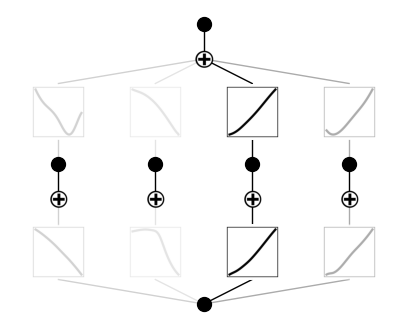

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[1,4,1], grid=7, k=3, seed=17, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: np.exp(1.83169-3.35509/x)
ranges = [0.1, 2.]
dataset = create_dataset(f, n_var=1, ranges=ranges, train_num=10000, test_num=1000, device=device)
res_kan_training = model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

saving model version 0.2


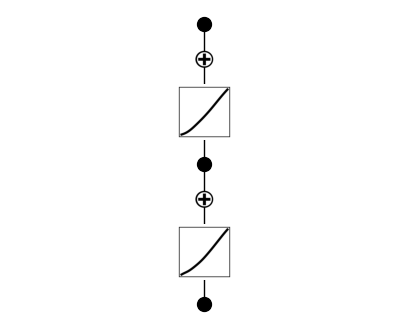

In [64]:
pruned_model = model.prune(node_th=0.2, edge_th=0.2)
pruned_model.plot()

(0, 0, 0)


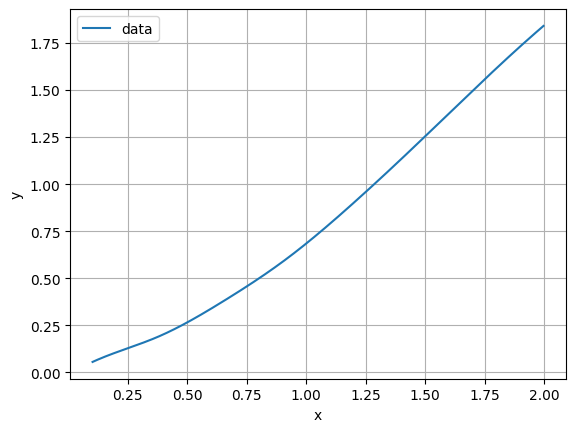

Checking constant function
Constant function is not a good fit.
Score:  -0.46086469641037703
Constant:  [0.80324905]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


Best score:  -0.007465292
Best ansatz:  params[0] + params[1] * x + params[2] * x**2
Best params:  [-0.01216797  0.45562161  0.24957552]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.36s/it]


Best score:  -0.0007262166
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [ 0.05275218  0.14323014  0.61068182 -0.11585741]
Generation: 2


100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.67s/it]

Best score:  -0.0001328054
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3 + params[4] * x**4
Best params:  [ 0.02542944  0.33450374  0.23746871  0.1534264  -0.0643569 ]
(1, 0, 0)


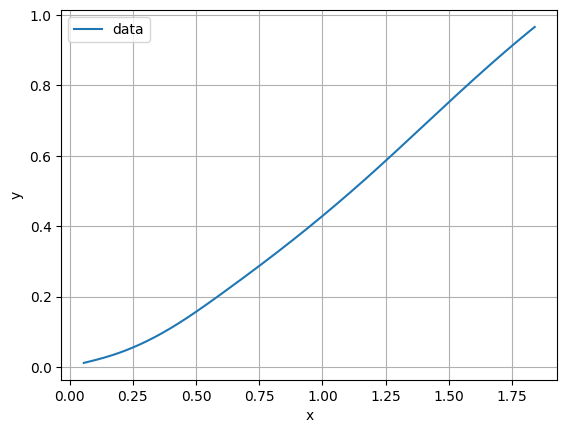

Checking constant function
Constant function is not a good fit.
Score:  -0.7303625011935906
Constant:  [0.35241341]
Generating Initial population population


100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.17s/it]


Best score:  -0.10589378
Best ansatz:  params[0] * x**2 + params[1]
Best params:  [0.29755728 0.07194676]
Generation: 1


100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.51s/it]


Best score:  -0.0052703503
Best ansatz:   params[0] * np.power(x, params[1])
Best params:  [0.4251504  1.38562676]
Generation: 2


 60%|██████████████████████████▍                 | 6/10 [00:14<00:09,  2.49s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Getting another response from LLM


 90%|███████████████████████████████████████▌    | 9/10 [00:23<00:02,  2.71s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Getting another response from LLM


100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]

Best score:  -0.0012210789
Best ansatz:   params[0] * x**3 + params[1] * x**2 + params[2] * x
Best params:  [-0.09020215  0.37011007  0.14923803]


In [65]:
sym_expr = LLMSR.kan_to_symbolic(pruned_model, client, gpt_model="openai/gpt-4o", exit_condition=min(res_kan_training['train_loss']).item())

In [66]:
symb_expr_sorted = {}
# build disctionary with all expressions ordered by score
for kan_conn, sub_res in sym_expr.items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    ordered_elements = sorted([item for sublist in sub_res for item in sublist], key=lambda item: -item['score'])
    symb_expr_sorted[kan_conn] = ordered_elements
    print(f"Approximation for {kan_conn}: {ordered_elements[0]['ansatz'].strip()}")
    print(f"Parameters are {np.round(ordered_elements[0]['params'], 1)}")

Approximation for (0, 0, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3 + params[4] * x**4
Parameters are [ 0.   0.3  0.2  0.2 -0.1]
Approximation for (1, 0, 0): params[0] * x**3 + params[1] * x**2 + params[2] * x
Parameters are [-0.1  0.4  0.1]


In [67]:
edge_dict_top_three, edge_dict = {}, {}
for kan_conn, sub_res in symb_expr_sorted.items():
    print(f"KAN Connection: {kan_conn}")
    scores, ansatze, params = [pop['score'] for pop in sub_res], [pop['ansatz'].replace('*x', ' * x').replace('(x)', '(1. * x)') for pop in sub_res], [pop['params'] for pop in sub_res]
    top_three_ansatze, top_three_params, top_three_scores = [], [], []
    for s, a, p in zip(scores, ansatze, params):
        a = a.strip()
        # weed out lambda functions
        if "lambda" in a:
            continue
        if a not in top_three_ansatze and round(s, 5) not in top_three_scores:
            top_three_ansatze.append(a)
            top_three_params.append(p)
            top_three_scores.append(round(s, 5))                
        if len(top_three_ansatze) >= 3:
            break
    top_three = []
    for a, p in zip(top_three_ansatze, top_three_params):
        top_three.append(subst_params(a, p))
    edge_dict_top_three[kan_conn] = top_three
    edge_dict[kan_conn] = top_three[0]
    print([(s,t) for s,t in zip(top_three, top_three_scores)])

KAN Connection: (0, 0, 0)
[('0.0254 + 0.3345 * x + 0.2375 * x**2 + 0.1534 * x**3 + -0.0644 * x**4', -0.00013), ('0.0528 + 0.1432 * x + 0.6107 * x**2 + -0.1159 * x**3', -0.00073), ('0.2598 * x**2 + 0.4312 * x', -0.00206)]
KAN Connection: (1, 0, 0)
[('-0.0902 * x**3 + 0.3701 * x**2 + 0.1492 * x', -0.00122), ('0.4252 * np.power(x, 1.3856)', -0.00527), ('0.1561 * x**2 + 0.2605 * x', -0.0249)]


###################################################
Simplifying output 0
KAN expression (raw):
 2.40915165568e-5*x0**12 - 0.0001721570794944*x0**11 + 0.0001435355659584*x0**10 + 0.0005687922644272*x0**9 + 0.0027654909748976*x0**8 - 0.0088791313221812*x0**7 - 0.0084177325567194*x0**6 + 0.001067181474029*x0**5 + 0.0397653271627334*x0**4 + 0.0800808354501186*x0**3 + 0.08050032666279*x0**2 + 0.056137964150988*x0 + 0.0040269756028272
KAN expression (simplified):
 -0.0002*x0**11 + 0.0001*x0**10 + 0.0006*x0**9 + 0.0028*x0**8 - 0.0089*x0**7 - 0.0084*x0**6 + 0.0011*x0**5 + 0.0398*x0**4 + 0.0801*x0**3 + 0.0805*x0**2 + 0.0561*x0 + 0.004
Refitting gave a chi^2 of 1.9300e-04
KAN expression (final):
 0.1374*x0**11 - 1.6323*x0**10 + 8.4135*x0**9 - 24.5318*x0**8 + 44.1016*x0**7 - 49.6667*x0**6 + 33.6525*x0**5 - 12.2181*x0**4 + 2.0318*x0**3 - 0.0483*x0**2 - 0.0234*x0 + 0.0018
Refitting gave a chi^2 of 7.4089e-03


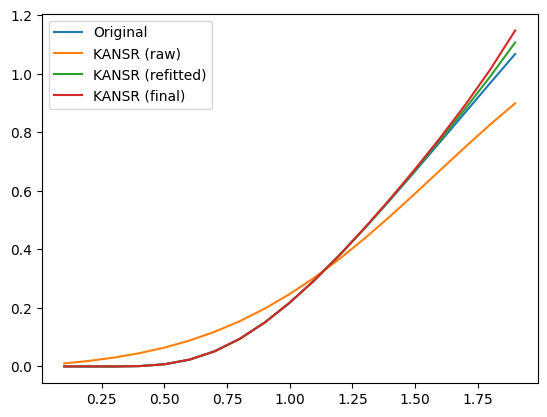

##################
# Final formula: #
##################
 x0**3*(0.0103*x0**8 - 0.2355*x0**7 + 1.7921*x0**6 - 6.8322*x0**5 + 14.8596*x0**4 - 18.9341*x0**3 + 13.3494*x0**2 - 4.2808*x0 + 0.4893)


In [71]:
# define an expression tree consisting of L layers, with N nodes, where node (l,n) = \sum_c expr(l,c,n)
# the KAN convention for the triples (l,c,n) is: (layer, coming from node in l-1, going to node in layer l)
node_tree = {}
for l in range(len(pruned_model.width_in) - 1):
        for n in range(pruned_model.width_in[l+1]):
            node_tree[(l, n)] = " + ".join([edge_dict[(l,c,n)].replace(' x', f' x[{l-1},{c}]' if l > 0 else f' x{c}') for c in range(pruned_model.width_out[l])])
for k, v in node_tree.items():
    node_tree[k] = v.replace('+ -','- ')

# Build full expression, prepopulate with output nodes
full_expression = []
for o in range(pruned_model.width_in[-1]):
    res = node_tree[len(pruned_model.width_in)-2, o]
    # traverse down lower layers
    for l in list(range(len(pruned_model.width_in)-2))[::-1]:
        for n in range(len([x for x in node_tree.keys() if x[0]==l])):
            res = res.replace(f'x[{l},{n}]', f'({node_tree[l, n]})')
    full_expression.append(simplify_expression(res, pruned_model.width_in[0] - 1))

# After simplification, prune (round coefficients to 4 digits), simplify again
final_expressions = []
for i, expr in enumerate(full_expression):
    print("###################################################")
    print(f"Simplifying output {i}")
    print("KAN expression (raw):\n", expr)
    f_fitted = lambda x0: eval(expr)
    xs = np.arange(ranges[0], ranges[1], .1)
    plt.plot(xs, [f(x) for x in xs], label="Original")
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (raw)")
    plt.legend();
    
    # prune and simplify
    expr = simplify_expression(subst_params(*replace_floats_with_params(expr)), pruned_model.width_in[0] - 1)
    print("KAN expression (simplified):\n", expr)

    # refit parameters
    curve_ansatz_str, params_initial = replace_floats_with_params(expr)
    for k, v in sympy_to_numpy.items():
        curve_ansatz_str = curve_ansatz_str.replace(k, v)
    
    curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
    curve = eval(curve_ansatz)
    try:
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")
    except RuntimeError as e:
        print(e)
        print("Proceeding with unoptimized parameters")
        params_opt = params_initial

    # prune and simplify refitted model
    expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
    print("KAN expression (final):\n", expr)
    final_expressions.append(expr)
    
    # plot comparison
    f_fitted = lambda x0: eval(expr)
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (refitted)")
    
    # Ask LLM to further simplify the result and refit.
    try:
        simp_call_reply = call_model_simplify(client, prompt=f"The interval is {ranges}. The function is {expr}.")
        expr = simp_call_reply.choices[0].message.content
        curve_ansatz_str, params_initial = replace_floats_with_params(expr)
        curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
        curve = eval(curve_ansatz)
        
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")    
        expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
        f_fitted = lambda x0: eval(expr)
        plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (final)")
    except Exception as e:
        print(e)
        print("Skipping LLM improvement.")
    
    plt.legend()
    plt.show()
    print("##################\n# Final formula: #\n##################\n", expr)